In [63]:
import pandas as pd

import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import pickle

tf.keras.backend.clear_session()  # For easy reset of notebook state.

from tensorflow import keras
from tensorflow.keras import layers

# Train a small grid of stellar models

Context: Tanda shared his simple grid of stellar models with me.  

Aim: train a simple NN to produce an emulated HR diagram.

Method: Use Keras

Results: Can make an emulated HR diagram with very little work.  More training is needed and architecture needs to be explored.  Some thought should be put into the activation function.  We should run tests on dropout and regularisation.

## The grid

For now I have a very simple grid for a single metalicity ([Fe/H] = 0).  We can load this in.

In [2]:
df_big = pd.read_csv('grid_0_0.csv')
print(len(df_big))
df_big.head()

40814


,Unnamed: 0,model_number,star_mass,star_age,star_feh,star_MLT,star_fov,effective_T,luminosity,radius,...,he_core_mass,delta_nu,delta_Pg,nu_max,nu_0_10,nu_0_11,nu_0_12,nu_0_13,nu_0_14,nu_0_15
0,0,1,0.8,1.000000e-14,0.0,1.9,0.018,4273.590386,162.346541,23.275262,...,0.0,1.075572,0.0,5.305350,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2,0.8,2.200000e-14,0.0,1.9,0.018,4270.299064,161.833501,23.274291,...,0.0,1.075640,0.0,5.307837,0.0,0.0,0.0,0.0,0.0,0.0
2,2,3,0.8,3.640000e-14,0.0,1.9,0.018,4266.421345,161.230577,23.273144,...,0.0,1.075719,0.0,5.310772,0.0,0.0,0.0,0.0,0.0,0.0
3,3,4,0.8,5.368000e-14,0.0,1.9,0.018,4261.797331,160.513336,23.271738,...,0.0,1.075817,0.0,5.314295,0.0,0.0,0.0,0.0,0.0,0.0
4,4,5,0.8,7.441600e-14,0.0,1.9,0.018,4255.748476,159.580020,23.269990,...,0.0,1.075938,0.0,5.318869,0.0,0.0,0.0,0.0,0.0,0.0


## Select inputs/outputs for the net

We are going to select the columns for the x, y data sets.  We will cast as float32 but in the future it might be neccessary to cast as float64 for better precsion although this is probably not going to be a limiting factor.

In [3]:
x_cols = ['star_mass', 'star_age']
y_cols = ['luminosity', 'effective_T']
x = np.log10(df_big[x_cols].values).astype('float32')
y = np.log10(df_big[y_cols].values).astype('float32')

## Setup the model of the NN using Keras.

In [159]:
New = True
n = int(128 * 2)
if New:
    inputs = keras.Input(shape=(len(x_cols),), name='time')
    xx = layers.Dense(n, activation='relu')(inputs)
    #xx = layers.Dense(n, activation='relu')(xx)
    #xx = layers.Dense(n, activation='relu')(xx)
    xx = layers.Dense(n, activation='relu')(xx)
    xx = layers.Dense(n, activation='relu')(xx)
    outputs = layers.Dense(len(y_cols), activation='linear')(xx)

    model = keras.Model(inputs=inputs, outputs=outputs, name='simple_model')
else:
    model = keras.models.load_model('small_grid_model.h5')

In [160]:
model.summary()

Model: "simple_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time (InputLayer)            [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 128)               384       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
Total params: 33,666
Trainable params: 33,666
Non-trainable params: 0
_________________________________________________________________


## Training

From work on simple functions I currently like the Nadam optimizer which is similar to Adam but with Nesterov momentum.  work on the simple tests suggests that Nadam is not a terrible choice.  

Work will be required on the learning rate and betas.  For now I favour use of the MAE loss function (note this is not a stats problem but an emulation problem).

In [161]:
opt = keras.optimizers.Nadam(lr=0.004, beta_1=0.9995, beta_2=0.999, epsilon=1e-9)
model.compile(loss='mean_absolute_error',
              optimizer=opt,
              metrics=['mae', 'mse'])

In [162]:
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    #if epoch % 10000 == 0: print('')
    if epoch % 1000 == 0: print('.', end='')

history = model.fit(x, y,
                    epochs=100000,
                    batch_size=len(df_big),
                    validation_split=0.00, verbose=0,
                    callbacks=[PrintDot()])

model.save('small_grid_model.h5')

....................................................................................................

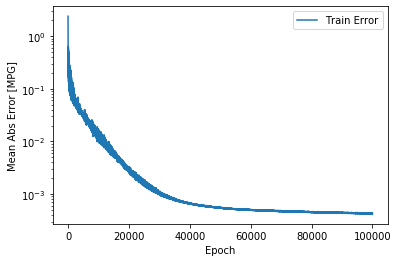

In [163]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.legend()
  plt.yscale('log')

plot_history(history)

In [164]:
train_scores = model.evaluate(x, y, verbose=2)
print('Train loss:', train_scores[0])
print('Train accuracy:', train_scores[1])

40814/1 - 3s - loss: 8.0964e-04 - mae: 4.2521e-04 - mse: 2.7695e-06
Train loss: 0.0004252111239520978
Train accuracy: 0.00042521107


In [165]:
y_pred = model.predict(x)

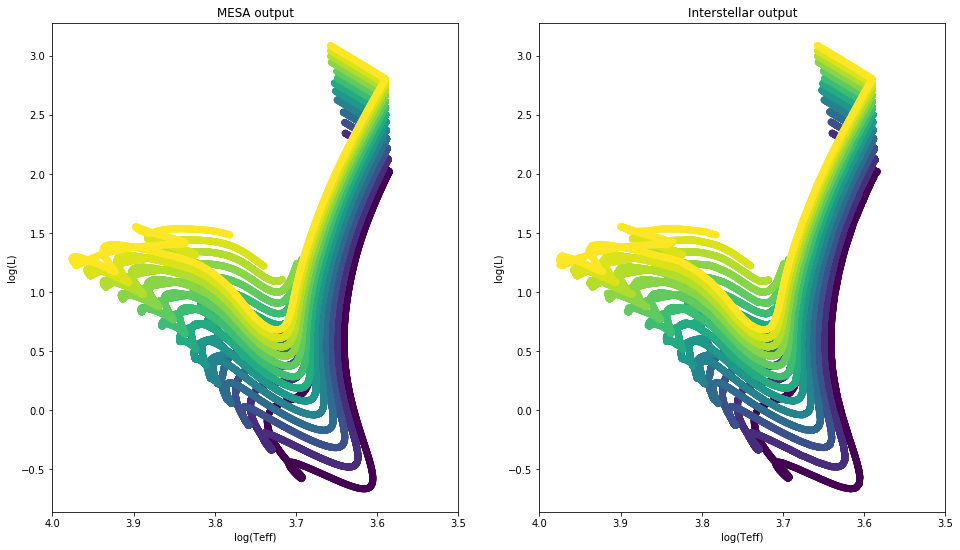

In [166]:
fig, ax = plt.subplots(1, 2, figsize=[16,9])
ax[0].scatter(y[:,1], y[:,0], c=x[:,0])
ax[1].scatter(y_pred[:,1], y_pred[:,0], c=x[:,0])
[n.set_xlim([4.0, 3.5]) for n in ax]
[n.set_xlabel('log(Teff)') for n in ax]
[n.set_ylabel('log(L)') for n in ax]
ax[0].set_title('MESA output')
ax[1].set_title('Interstellar output')
fig.savefig('interstellar_v0.png')

In [167]:
with open('weights_file.data', 'wb') as filehandle:
    # store the data as binary data stream
    pickle.dump(model.get_weights(), filehandle)

(-0.001, 0.001)

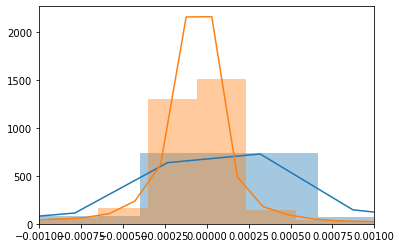

In [172]:
sns.distplot(y[:,0] - y_pred[:,0])
sns.distplot(y[:,1] - y_pred[:,1])
plt.xlim([-0.001, 0.001])